# Can We Agree on Science

### Preparation


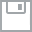
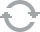
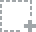
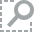
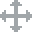
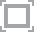
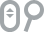
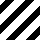
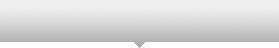
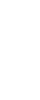
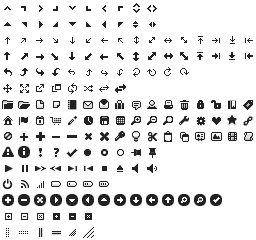
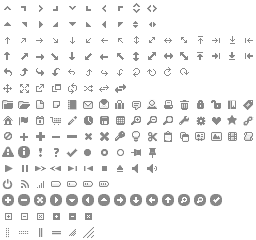
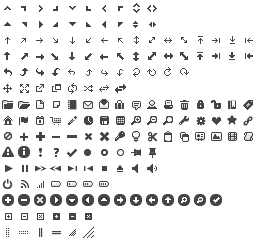
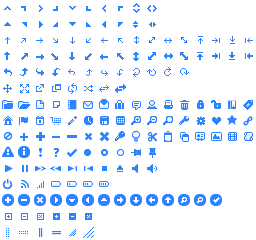
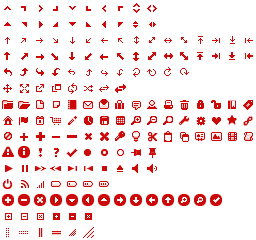
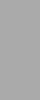
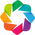
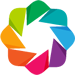

In [1]:
%matplotlib inline
import pylab as plt
import pickle
import random
import numpy as np
from igraph import *
from scipy import stats
import pandas as pd
from collections import Counter
import seaborn as sns
from bokeh.plotting import ColumnDataSource, figure, output_notebook, output_file, show
from bokeh.models import HoverTool
output_notebook()
TOOLS = 'wheel_zoom,box_zoom,pan,reset,save,hover'

In [2]:
classification=pickle.load(open('../BookCodes/top_classifications.pkl'))
print "Classifications loaded. E.g., classification['0887381324']={}".format(classification['0887381324'])
print "How many ISBNs' have Dewey codes: {}".format(Counter([len(classification[x]['dewey'])>0 for x in classification]))
print "How many ISBNs' have LoC codes: {}".format(Counter([len(classification[x]['loc'])>0 for x in classification]))
T_loc=pickle.load(open('../Classifications/loc_tree.pkl'))
T_dd=pickle.load(open('../Classifications/dd_tree.pkl'))
g = pickle.load(open('../AmazonBooks/asin_network.pkl','rb'))
print "Co-purchase network loaded: {}".format(g.summary())
asin2id = pickle.load(open('../AmazonBooks/asin2id.pkl','r'))
isbn2asin = pickle.load(open('../AmazonBooks/isbn_lookup.pkl'))
asin2isbn=pickle.load(open("../AmazonBooks/asin_lookup.pkl"))

Classifications loaded. E.g., classification['0887381324']={'loc': 'HD9574.E22', 'dewey': '338.2728209866'}
How many ISBNs' have Dewey codes: Counter({True: 1234620, False: 51471})
How many ISBNs' have LoC codes: Counter({True: 1219499, False: 66592})
Co-purchase network loaded: IGRAPH UN-- 1303504 26467385 -- 
+ attr: name (v), title (v)


#### Populate books into Dewey and LoC classification trees

In [3]:
import locclass

for t in T_loc.vs:
    t['books']=set()
for t in T_dd.vs:
    t['books']=set()

for isbn in classification:
    #for j in classification[isbn]['dewey']:
    if classification[isbn]['dewey']:
        j=classification[isbn]['dewey']
        code=j.split('.')[0]
        if not code.isdigit():
            continue
        if len(code)>3:
            continue
        t=T_dd.vs.find(code)
        t['books'].add(asin2id[isbn2asin[isbn]])
        #t['books'].add(isbn2id[isbn])
    #for code in classification[isbn]['loc']:
    if classification[isbn]['loc']:
        code = classification[isbn]['loc']
        if code:
            topic=locclass.locclass(code)
            t=T_loc.vs.find(topic)
            t['books'].add(asin2id[isbn2asin[isbn]])
            #t['books'].add(isbn2id[isbn])

In [4]:
def traverse(T,node,depth):
    T.vs[node]['depth']=depth
    for u in T.neighbors(node,OUT):
        traverse(T,u,depth+1)
        T.vs[node]['books']|= T.vs[u]['books']
    T.vs[node]['size']=len(T.vs[node]['books'])

In [5]:
traverse(T_dd,0,0)
traverse(T_loc,0,0)

#### Build our classification trees

In [6]:
def buildTree(filename='disciplines.txt',source='combine',rootname='Root'):
    infile=open(filename)
    for i,l in enumerate(infile): # in case excel does not use \n to end lines
        if i>0:
            break
    infile.close()
    if i==0:  
        infile=l.split('\r')
    else:
        infile=open(filename)
    field=None
    discipline=None
    T=Graph(directed=True)
    T.add_vertex(name=rootname,label=rootname,depth=0)
    T.vs.find(rootname)['books']=set()
    for l in infile:
        items=l.split('\t')
        if items[0] and (not items[1]) and (not items[2]) and (not items[3]):
            T.add_vertex(name=items[0],label=items[0],depth=1)
            field=T.vs.find(items[0])
            T.add_edge(rootname,field)
            field['books']=set()
        elif items[0] and (not items[1]) and items[2] and (not items[3]):
            T.add_vertex(name=field['name']+'/'+items[0],label=items[0],depth=2)
            discipline=T.vs.find(field['name']+'/'+items[0])
            T.add_edge(field,discipline)
            discipline['books']=set()
        elif items[0] or items[2]:
            if items[0] and (source=='dd' or source=='combine'):
                T.add_vertex(name=items[0],label=items[1],depth=3)
                t=T.vs.find(items[0])
                t['books']=T_dd.vs.find(items[0])['books']
                T.add_edge(discipline,t)
            if items[2] and (source=='loc' or source=='combine'):
                T.add_vertex(name=items[2],label=items[3],depth=3)
                t=T.vs.find(items[2])
                t['books']=T_loc.vs.find(items[2])['books']
                T.add_edge(discipline,t)
    return T

* Science tree

In [7]:
infile='../Disciplines/disciplines(05-13).txt'
D_loc=buildTree(filename=infile,source='loc',rootname='Sciences')
D_dd=buildTree(filename=infile,source='dd',rootname='Sciences')
D_com=buildTree(filename=infile,source='combine',rootname='Sciences')

* Nonscience tree

In [8]:
infile='../Disciplines/nonsciences.txt'
N_loc=buildTree(filename=infile,source='loc',rootname='Nonsciences')
N_dd=buildTree(filename=infile,source='dd',rootname='Nonsciences')
N_com=buildTree(filename=infile,source='combine',rootname='Nonsciences')

#### Visulaize the tree

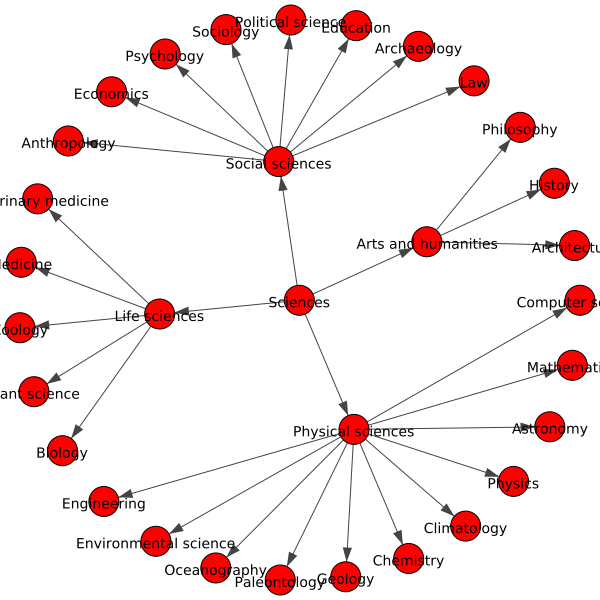

In [9]:
plot(D_loc.vs(depth_le=2).subgraph(),
     layout=D_loc.vs(depth_le=2).subgraph().layout_reingold_tilford_circular(root=0),
     vertex_label=D_loc.vs(depth_le=2)['label'],vertex_size=30)

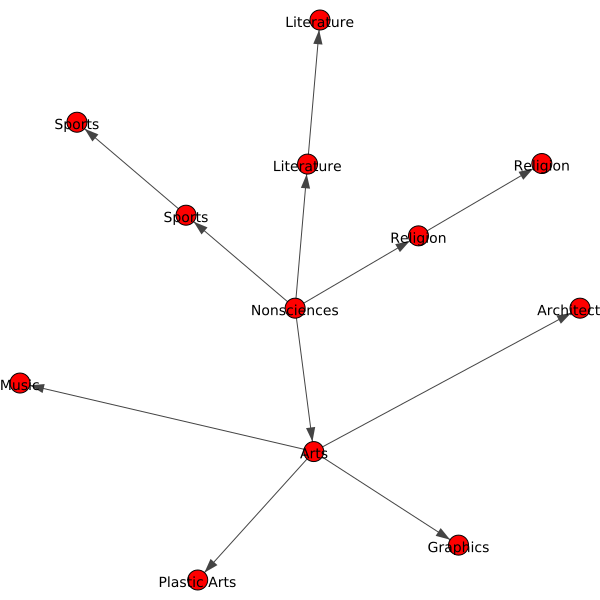

In [10]:
plot(N_loc.vs(depth_le=2).subgraph(),
     layout=N_loc.vs(depth_le=2).subgraph().layout_reingold_tilford_circular(root=0),
     vertex_label=N_loc.vs(depth_le=2)['label'],vertex_size=20)

#### Populate books into the trees

In [11]:
traverse(D_dd,0,0)
traverse(D_loc,0,0)
traverse(D_com,0,0)

In [12]:
traverse(N_dd,0,0)
traverse(N_loc,0,0)
traverse(N_com,0,0)

#### Build intersection tree

In [13]:
D_int=D_com.vs(depth_le=2).subgraph()
for v in D_int.vs:
    v['books']=D_loc.vs.find(v['name'])['books'] & D_dd.vs.find(v['name'])['books']
    v['size']=len(v['books'])

In [14]:
N_int=N_com.vs(depth_le=2).subgraph()
for v in N_int.vs:
    v['books']=N_loc.vs.find(v['name'])['books'] & N_dd.vs.find(v['name'])['books']
    v['size']=len(v['books'])

#### Number of books

In [15]:
df=pd.DataFrame({"Discipline":D_int.vs['name'],
                 "Combined":[D_com.vs.find(i['name'])['size'] for i in D_int.vs],
                 "Intersect":[D_int.vs.find(i['name'])['size'] for i in D_int.vs],
                 "Dewey":[D_dd.vs.find(i['name'])['size'] for i in D_int.vs],
                 "LoC":[D_loc.vs.find(i['name'])['size'] for i in D_int.vs],
                 "Level":D_int.vs['depth']},
                 columns=["Discipline","Dewey","LoC","Combined","Intersect","Level"]).append(
    pd.DataFrame({"Discipline":N_int.vs['name'],
                 "Combined":[N_com.vs.find(i['name'])['size'] for i in N_int.vs],
                 "Intersect":[N_int.vs.find(i['name'])['size'] for i in N_int.vs],
                 "Dewey":[N_dd.vs.find(i['name'])['size'] for i in N_int.vs],
                 "LoC":[N_loc.vs.find(i['name'])['size'] for i in N_int.vs],
                 "Level":N_int.vs['depth']},
                 columns=["Discipline","Dewey","LoC","Combined","Intersect","Level"]))
print df[df.Level<=1].to_string(index=False)

          Discipline   Dewey     LoC  Combined  Intersect  Level
            Sciences  347510  359974    428431     279053      0
   Physical sciences   78480   75628     91793      62315      1
       Life sciences   75088   79905     90872      64121      1
     Social sciences  101601   91697    134259      59039      1
 Arts and humanities   92452  112818    128292      76978      1
         Nonsciences  435688  368628    494278     310038      0
                Arts  103514   52604    113581      42537      1
              Sports   47405   17052     49878      14579      1
          Literature  192065  255109    269487     177687      1
            Religion   92854   43903     97271      39486      1


###  Book Level

#### Calculate alignment of books

In [16]:
liberals=set()
with open('../BookCodes/liberals1008.txt') as l:
    for line in l:
        liberals.add(asin2id[isbn2asin[line.strip()]])

conservatives=set()
with open('../BookCodes/conservatives1008.txt') as c:
    for line in c:
        conservatives.add(asin2id[isbn2asin[line.strip()]])

for u in g.vs:
    u['color']=[0,0,0]

for u in liberals:
    g.vs[u]['color'][2]=1

for u in conservatives:       
    g.vs[u]['color'][0]=1

In [17]:
count=0
for u in g.vs:
    #if count%10000==0:
        #print '{} '.format(count),
    count+=1
    kr=0
    kb=0
    for v in u.neighbors():
        if v['color'][2]==1:
            kb+=1
        if v['color'][0]==1:
            kr+=1
    u['kb']=kb
    u['kr']=kr

d=g.vs(color=[0,0,0])
d=np.add(d['kr'],d['kb'])
Ed=d[d>0].mean()
kr=sum(g.vs(color=[1,0,0]).degree())
kb=sum(g.vs(color=[0,0,1]).degree())
fred=1.0*kr/(kr+kb)
fblue=1.0*kb/(kr+kb)
redness=dict()
count=0
for u in g.vs:
    #if count%10000==0:
        #print '{} '.format(count),
    count+=1
    if u['color']==[0,0,0]:
        kr=u['kr']
        kb=u['kb']
        k=kb+kr
        if k==0:
            continue
        a=Ed*fblue+kb
        b=Ed*fred+kr
        r=b/(a+b)
        if r<=fred:
            r=r/fred*0.5
        else:
            r=(r-fred)/fblue*0.5+0.5
        redness[u.index]=r
        u['color'][0]=r
        u['color'][2]=1-r
    else:
        redness[u.index]=u['color'][0]

#### Add publisher data

In [18]:
isbn2publisher=pickle.load(open("../AmazonBooks/isbn2publisher.pkl"))

In [19]:
academicPublisher={}
with open("../AmazonBooks/academic_publishers.txt") as infile:
    for line in infile:
        key,v = line.split('\t')
        academicPublisher[key.strip()]=int(v.strip())

In [20]:
for u in g.vs:
    academic=0
    for isbn in asin2isbn[u['name']]:
        if isbn2publisher[isbn].lower() in academicPublisher:
            if academicPublisher[isbn2publisher[isbn].lower()]==1:
                academic=1
                break
        elif ('university' in isbn2publisher[isbn].lower()) or ('academic' in isbn2publisher[isbn].lower()):
            academic=1
            break
    u['academic']=academic

#### Consistency of book alignment

In [21]:
blueIndex=[]
redIndex=[]
for u in g.vs:
    if u['color']==[1,0,0]:
        kr=u['kr']
        kb=u['kb']
        k=kb+kr
        if k!=0:
            redIndex.append(u.index)
    elif u['color']==[0,0,1]:
        kr=u['kr']
        kb=u['kb']
        k=kb+kr
        if k!=0:
            blueIndex.append(u.index)

In [22]:
kRed=sum(g.vs(redIndex).degree())
kBlue=sum(g.vs(blueIndex).degree())
kRed*1.0/(kRed+kBlue),fred

(0.6760796213682375, 0.6622330542744104)

In [23]:
ideologyBooks={}
for u in g.vs(list(set(blueIndex) | set(redIndex))):
    kr=u['kr']
    kb=u['kb']
    k=kb+kr
    if k==0:
        ideologyBooks[u['name']]=0
        continue
    a=Ed*fblue+kb
    b=Ed*fred+kr
    r=b/(a+b)
    if r<=fred:
        r=r/fred*0.5
    else:
        r=(r-fred)/fblue*0.5+0.5
    ideologyBooks[u['name']]=r

df=pd.DataFrame({'ASIN':ideologyBooks.keys(),
                 'alignment':ideologyBooks.values(),
                 'ideology':map(lambda x:g.vs.find(x)['color'][0],ideologyBooks.keys()),
                 'title':map(lambda x:g.vs.find(x)['title'],ideologyBooks.keys()),
                 'k':map(lambda x:g.vs.find(x).degree(),ideologyBooks.keys())})

/home/ubuntu/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


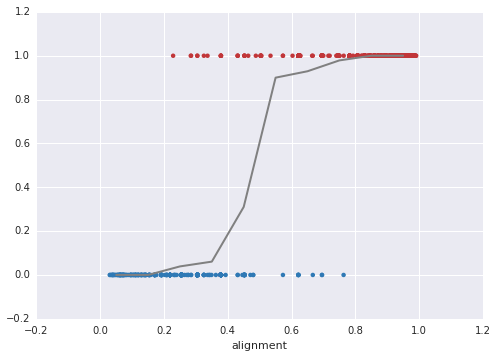

In [24]:
df2=df[df.alignment>0]
xbins=np.arange(0,1.1,0.1)
books,_=np.histogram(df2['alignment'],xbins)
redBooks,_=np.histogram(df2['alignment'],xbins,weights=df2['ideology'])
y=np.zeros_like(redBooks,dtype=float)
y[books!=0]=1.0*redBooks[books!=0]/books[books!=0]
sns.set_palette("RdBu_r")
plt.scatter(df2['alignment'],df2['ideology'],c=map(lambda x: [ 0.18431374,0.47266437,0.71164938] if x==0 else [ 0.75617072, 0.21038063,  0.22352942], df2['ideology']),edgecolors='none')
plt.plot((xbins[1:]+xbins[:-1])/2,y,lw=2,color='grey')
plt.xlabel('alignment');

/home/ubuntu/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


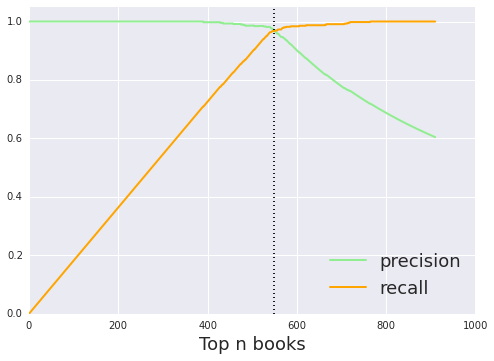

In [25]:
df3=df2[['alignment','ideology']]
total=df3['ideology'].sum()
df3=df3.sort('alignment',ascending=False)
precision=[]
recall=[]
x=range(1,df3.shape[0]+1)
for i in x:
    books=df3['ideology'].iloc[:i].sum()
    precision.append(1.0*books/i)
    recall.append(1.0*books/total)
    
plt.plot(x,precision,color='lightgreen',lw=2)
plt.plot(x,recall,color='orange', lw=2)
plt.plot([total,total],[0,1.05],':',color='k')
plt.ylim([0,1.05])
plt.legend(['precision','recall'],fontsize=18,loc='best')
plt.xlabel('Top n books',fontsize=18);

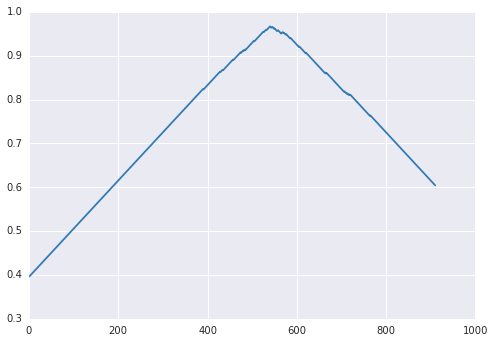

In [26]:
correlation=[]
for i in xrange(1,df3.shape[0]+1):
    imputed=np.zeros_like(df3['ideology'])
    imputed[:i]=1
    #correlation.append(stats.pearsonr(imputed,df3['ideology']))
    correlation.append((imputed==df3['ideology']).sum()*1.0/len(imputed))
plt.plot(xrange(1,df3.shape[0]+1),correlation);

In [29]:
print "Max correlation achieved at cutting at top {} books".format(np.argmax(correlation))
print "If cutting at top 539 books, correlation is {}".format(correlation[539])
print df3.iloc[539]

Max correlation achieved at cutting at top 539 books
If cutting at top 546 books, correlation is 0.967032967033
alignment    0.488034
ideology     1.000000
Name: 771, dtype: float64


### Aggregated Level

#### Calculate alignment and polarization

In [48]:
def calculate(T):
    # Leaves of the tree
    for t in T.vs:
        t['color']=[0,0,0]
        if t['books']:
            t['kr']=sum(g.vs[list(t['books'])]['kr'])
            t['kb']=sum(g.vs[list(t['books'])]['kb'])
        else:
            t['kr']=0
            t['kb']=0

    T2=T.copy()
    T2.vs['out_degree']=T2.degree(mode=OUT)
    d=T2.vs.select(out_degree=0)
    d=np.add(d['kr'],d['kb'])
    Ed=10#np.median(d[d>0])

    for leaf in T2.vs.select(out_degree=0):
        u=T.vs.find(leaf['name'])
        k=leaf['kb']+leaf['kr']
        a=Ed*fblue+leaf['kb']
        b=Ed*fred+leaf['kr']
        r=b/(a+b)
        if r<=fred:
            r=r/fred*0.5
        else:
            r=(r-fred)/fblue*0.5+0.5
        u['color']=[r,0,1-r]
        u['ci']=[]
        for r in stats.beta.interval(0.9,b,a):
            if r<=fred:
                r=r/fred*0.5
            else:
                r=(r-fred)/fblue*0.5+0.5
            u['ci'].append(r)
        r=[]
        if k>0:
            for b in leaf['books']:
                if b in redness:
                    r.append(redness[b])
            pola=np.array(r)-0.5
            pola1=np.mean(pola[pola>=0]) if pola[pola>=0].size else 0
            pola2=np.mean(pola[pola<0]) if pola[pola<0].size else 0
            u['polarization']=pola1-pola2
            #u['polarization']=np.mean(np.maximum(np.array(r),1-np.array(r)))
            #u['polarization_std']=np.std(np.maximum(np.array(r),1-np.array(r)))/np.sqrt(len(r))
            books=g.vs(list(leaf['books']))
            kr=np.array(books['kr'])
            kb=np.array(books['kb'])
            #u['polarization2']=1.0*sum((kr*kb)>0)/sum((kr+kb)>0)
        else:
            u['polarization']=0
            #u['polarization_std']=0
            #u['polarization2']=0
        u['strength']=np.sum(g.vs[list(u['books'])].degree(), dtype=float) - g.vs[list(u['books']-conservatives-liberals)].subgraph().ecount()*2
        u['psize']=len(r)
        if leaf['books']:
            u['academic']=sum(g.vs(list(leaf['books']))['academic'])*1.0/u['size']
        else:
            u['academic']=0
    T2.delete_vertices(T2.vs.select(out_degree=0))

    # Internal nodes of the tree
    while T2:
        T2.vs['out_degree']=T2.degree(mode=OUT)
        d=T2.vs.select(out_degree=0)
        d=np.add(d['kr'],d['kb'])
        #Ed=np.median(d[d>0])
        for leaf in T2.vs.select(out_degree=0):
            u=T.vs.find(leaf['name'])
            kb=u['kb']
            kr=u['kr']
            k=kb+kr
            a=Ed*fblue+kb
            b=Ed*fred+kr
            r=b/(a+b)
            if r<=fred:
                r=r/fred*0.5
            else:
                r=(r-fred)/fblue*0.5+0.5
            u['color']=[r,0,1-r]
            u['ci']=[]
            for r in stats.beta.interval(0.9,b,a):
                if r<=fred:
                    r=r/fred*0.5
                else:
                    r=(r-fred)/fblue*0.5+0.5
                u['ci'].append(r)
            r=[]
            if k>0:
                for b in u['books']:
                    if b in redness:
                        r.append(redness[b])
                pola=np.array(r)-0.5
                pola1=np.mean(pola[pola>=0]) if pola[pola>=0].size else 0
                pola2=np.mean(pola[pola<0]) if pola[pola<0].size else 0
                u['polarization']=pola1-pola2
                #u['polarization']=np.mean(np.maximum(np.array(r),1-np.array(r)))
                #u['polarization_std']=np.std(np.maximum(np.array(r),1-np.array(r)))/np.sqrt(len(r))
                books=g.vs(list(leaf['books']))
                kr=np.array(books['kr'])
                kb=np.array(books['kb'])
                #u['polarization2']=1.0*sum((kr*kb)>0)/sum((kr+kb)>0)
            else:
                u['polarization']=0
                #u['polarization2']=0
                #u['polarization_std']=0
            u['strength']=np.sum(g.vs[list(u['books'])].degree(), dtype=float) - g.vs[list(u['books']-conservatives-liberals)].subgraph().ecount()*2
            u['psize']=len(r)
            if leaf['books']:
                u['academic']=sum(g.vs(list(leaf['books']))['academic'])*1.0/u['size']
            else:
                u['academic']=0
        T2.delete_vertices(T2.vs.select(out_degree=0))

In [49]:
calculate(D_com)
calculate(D_dd)
calculate(D_loc)

In [50]:
calculate(N_com)
calculate(N_dd)
calculate(N_loc)

#### Calculate relevance

In [51]:
def calculateRelevance(T):
    fPolitical=(sum(g.vs(color=[1,0,0]).degree())+sum(g.vs(color=[0,0,1]).degree()))*1.0/g.ecount()/2
    Ed=10.0
    for u in T.vs:
        u['relevance']=(u['kr']+u['kb']+Ed*fPolitical)/(u['strength']+Ed)

In [52]:
calculateRelevance(D_com)
calculateRelevance(D_dd)
calculateRelevance(D_loc)

In [53]:
calculateRelevance(N_com)
calculateRelevance(N_dd)
calculateRelevance(N_loc)

#### Calculate centrality

In [54]:
def calculateCentrality(T):
    for u in T:
        books=np.array(list(u['books']))
        relevantBooks=books[np.array(g.vs[list(books)]['kr'])+np.array(g.vs[list(books)]['kb'])>0]
        redbooks=set()
        bluebooks=set()
        for b in relevantBooks:
            for neighbor in g.neighbors(b):
                if neighbor in conservatives:
                    redbooks.add(neighbor)
                if neighbor in liberals:
                    bluebooks.add(neighbor)
        if redbooks:
            u['redcentrality']=np.count_nonzero(g.vs[list(books)]['kr'])*1.0/len(redbooks)
        else:
            u['redcentrality']=0
        if bluebooks:
            u['bluecentrality']=np.count_nonzero(g.vs[list(books)]['kb'])*1.0/len(bluebooks)
        else:
            u['bluecentrality']=0

In [55]:
calculateCentrality(D_com.vs(depth=2))
calculateCentrality(D_loc.vs(depth=2))
calculateCentrality(D_dd.vs(depth=2))

#### Calculate academics

In [56]:
def calculateAcademics(T):
    for u in T:
        books=np.array(list(u['books']))
        redbooks=books[np.array(g.vs[list(books)]['kr'])>0]
        if redbooks.size>0:
            u['redacademic']=np.sum(g.vs[list(redbooks)]['academic'],dtype=float)/len(redbooks)
        else:
            u['redacademic']=0
        bluebooks=books[np.array(g.vs[list(books)]['kb'])>0]
        if bluebooks.size>0:
            u['blueacademic']=np.sum(g.vs[list(bluebooks)]['academic'],dtype=float)/len(bluebooks)
        else:
            u['blueacademic']=0

In [57]:
calculateAcademics(D_com.vs(depth=2))
calculateAcademics(D_loc.vs(depth=2))
calculateAcademics(D_dd.vs(depth=2))

#### Calculate closeness

In [138]:
def calculateCloseness(T):
    for u in T:
        Gsub=g.vs[list(u['books'])].subgraph()
        redbooks=np.nonzero(Gsub.vs['kr'])[0]
        if redbooks.size>0:
            u['redclose']=np.mean(Gsub.closeness(redbooks))
        else:
            u['redclose']=0
        bluebooks=np.nonzero(Gsub.vs['kb'])[0]
        if bluebooks.size>0:
            u['blueclose']=np.mean(Gsub.closeness(bluebooks))
        else:
            u['blueclose']=0

In [ ]:
#calculateAcademics(D_com.vs(depth=2))
calculateCloseness(D_loc.vs(depth=2))
#calculateAcademics(D_dd.vs(depth=2))

### Results

In [58]:
science=D_loc
nonscience=N_loc

In [94]:
df=pd.DataFrame({'relevance':science.vs['relevance'],
                 'label':science.vs['label'],
                 'polarization':science.vs['polarization'],
                 'alignment':zip(*science.vs['color'])[0],
                 'depth':science.vs['depth']},
                columns=['label','relevance','polarization','alignment','depth']).append(
                pd.DataFrame({'relevance':nonscience.vs['relevance'],
                 'label':nonscience.vs['label'],
                 'polarization':nonscience.vs['polarization'],
                 'alignment':zip(*nonscience.vs['color'])[0],
                 'depth':nonscience.vs['depth']},
                columns=['label','relevance','polarization','alignment','depth']))
print df[df['depth']<2].sort('polarization').to_string(index=False)
#df[df['depth']<=2].sort('depth').to_csv('../Disciplines/science.tsv',sep='\t',index=False)

                  label  relevance  polarization  alignment  depth
                   Arts   0.000374      0.261539   0.271483      1
                 Sports   0.000970      0.266416   0.463964      1
          Life sciences   0.000935      0.308162   0.497996      1
    Nonsciences overall   0.001930      0.324181   0.461403      0
             Literature   0.001889      0.328389   0.452968      1
      Physical sciences   0.001623      0.338766   0.476529      1
               Religion   0.002419      0.338834   0.504674      1
    Arts and humanities   0.013643      0.370603   0.537301      1
 Sciences & scholarship   0.012218      0.382435   0.523892      0
        Social sciences   0.012886      0.406416   0.518596      1


/home/ubuntu/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


#### Science vs nonscience

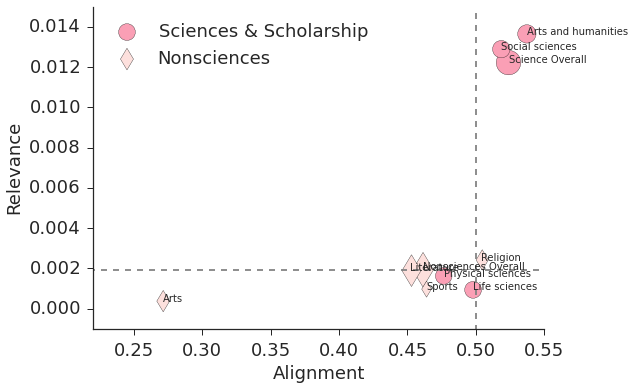

In [61]:
sns.set(style="ticks")
nodes=science.vs(depth_le=1)
science.vs.find('Sciences')['label']='Science Overall'
plt.scatter(zip(*nodes['color'])[0],
            nodes['relevance'],
            np.array(nodes['size'])**0.5,
            '#fa9fb5','o',label='Sciences & Scholarship')
for u in nodes:
    plt.text(u['color'][0],u['relevance'],u['label'])
nodes=nonscience.vs(depth_le=1)
nonscience.vs.find('Nonsciences')['label']='Nonsciences Overall'
plt.scatter(zip(*nodes['color'])[0],
            nodes['relevance'],
            np.array(nodes['size'])**0.5,
            '#fde0dd','d',label='Nonsciences')
plt.legend(loc=2,fontsize=18, markerscale=0.8,scatterpoints=1,numpoints=1)
for u in nodes:
    plt.text(u['color'][0],u['relevance'],u['label'])
plt.ylim([-0.001,0.015]);
plt.xlim([0.22,0.55])
sns.despine()
plt.plot([0.2,0.6],[df[df['depth']<=1]['relevance'].median()]*2,'--',color='grey')
plt.plot([0.5,0.5],[-0.01,0.02],'--',color='grey');
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlabel('Alignment',fontsize=18)
plt.ylabel('Relevance',fontsize=18);
plt.tight_layout()
#plt.savefig('../Disciplines/alignmentxrelevance.pdf')

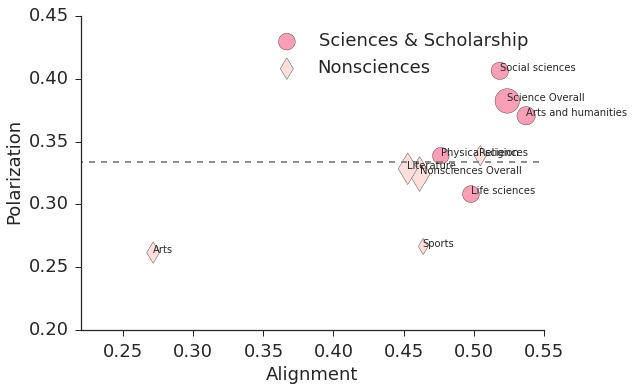

In [66]:
sns.set(style="ticks")
science.vs.find('Sciences')['label']='Science Overall'
nodes=science.vs(depth_le=1)
plt.scatter(zip(*nodes['color'])[0],
            nodes['polarization'],
            np.array(nodes['size'])**0.5,
            '#fa9fb5','o')
for u in nodes:
    plt.text(u['color'][0],u['polarization'],u['label'])
nonscience.vs.find('Nonsciences')['label']='Nonsciences Overall'
nodes=nonscience.vs(depth_le=1)
plt.scatter(zip(*nodes['color'])[0],
            nodes['polarization'],
            np.array(nodes['size'])**0.5,
            '#fde0dd','d')
plt.legend(['Sciences & Scholarship','Nonsciences'],loc='best',fontsize=18, markerscale=0.8,scatterpoints=1)
for u in nodes:
    plt.text(u['color'][0],u['polarization'],u['label'])
#plt.ylim([0.63,0.70]);
plt.xlim([0.22,0.55])
sns.despine()
plt.plot([0.2,0.6],[df[df['depth']<=1]['polarization'].median()]*2,'--',color='grey')
#plt.plot([0.5,0.5],[0,1],'--',color='grey');
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlabel('Alignment',fontsize=18)
plt.ylabel('Polarization',fontsize=18);
plt.tight_layout()
#plt.savefig('../Disciplines/alignmentxpolarization.pdf')

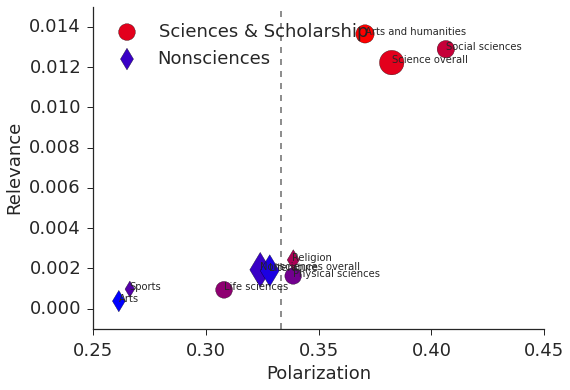

In [71]:
sns.set(style="ticks")
#cmin=min(zip(*D_com.vs(depth_le=1)['color'])[0]+zip(*N_com.vs(depth_le=1)['color'])[0])
#cmax=max(zip(*D_com.vs(depth_le=1)['color'])[0]+zip(*N_com.vs(depth_le=1)['color'])[0])
#cm=[[(c[0]-cmin)/(cmax-cmin),0,(cmax-c[0])/(cmax-cmin)] for c in D_com.vs(depth_le=1)['color']+N_com.vs(depth_le=1)['color']]
nodes1=science.vs(depth_le=1)
nodes2=nonscience.vs(depth_le=1)
cm=np.linspace(0,1,10)[stats.rankdata(zip(*nodes1['color'])[0]+zip(*nodes2['color'])[0]).astype(int)-1]
cm=zip(cm,[0]*len(cm),1-cm)
science.vs.find('Sciences')['label']='Science overall'
plt.scatter(nodes1['polarization'],
            nodes1['relevance'],
            np.array(nodes1['size'])**0.5,
            cm[:len(nodes1)],'o')
for u in nodes1:
    plt.text(u['polarization'],u['relevance'],u['label'])
nonscience.vs.find('Nonsciences')['label']='Nonsciences overall'
plt.scatter(nodes2['polarization'],
            nodes2['relevance'],
            np.array(nodes2['size'])**0.5,
            cm[len(nodes1):],'d')
plt.legend(['Sciences & Scholarship','Nonsciences'],loc=2,fontsize=18, markerscale=0.8,scatterpoints=1)
for u in nodes2:
    plt.text(u['polarization'],u['relevance'],u['label'])
plt.ylim([-0.001,0.015]);
#plt.xlim([0.63,0.70])
sns.despine()
#plt.plot([0.63,0.70],[df[df['depth']<=1]['relevance'].median()]*2,'--',color='grey')
plt.plot([df[df['depth']<=1]['polarization'].median()]*2,[-0.001,0.02],'--',color='grey');
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlabel('Polarization',fontsize=18)
plt.ylabel('Relevance',fontsize=18);
plt.tight_layout()
#plt.savefig('../Disciplines/polarizationxrelevance.pdf')

#### Scientific disciplines

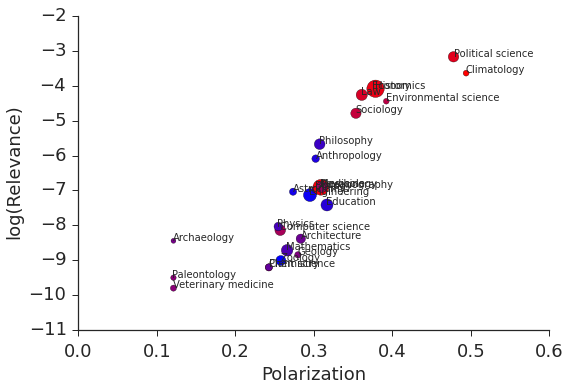

In [72]:
sns.set(style="ticks")
nodes=science.vs(depth=2)
cm=np.linspace(0,1,len(nodes))[stats.rankdata(zip(*nodes['color'])[0]).astype(int)-1]
cm=zip(cm,[0]*len(cm),1-cm)
science.vs.find('Sciences')['label']='Sciences & scholarship'
plt.scatter(nodes['polarization'],
            np.log(nodes['relevance']),
            np.array(nodes['size'])**0.5,
            cm,'o')
for u in nodes:
    plt.text(u['polarization'],np.log(u['relevance']),u['label'])
#plt.ylim([-10,-3]);
#plt.xlim([0.62,0.74])
sns.despine()
#plt.plot([0.6,0.8],[np.median(np.log(nodes['relevance']))]*2,'--',color='grey')
#plt.plot([np.median(nodes['polarization'])]*2,[-10,-3],'--',color='grey');
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlabel('Polarization',fontsize=18)
plt.ylabel('log(Relevance)',fontsize=18);
plt.tight_layout()
#plt.savefig('../Disciplines/polarizationXrelevance_27disciplines.pdf')

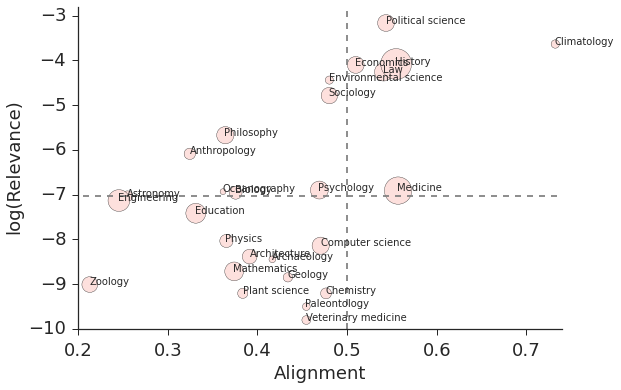

In [73]:
sns.set(style="ticks")
nodes=science.vs(depth=2)
science.vs.find('Sciences')['label']='Sciences & scholarship'
plt.scatter(zip(*nodes['color'])[0],
            np.log(nodes['relevance']),
            np.array(nodes['size'])**0.6,
            '#fde0dd','o')
for u in nodes:
    plt.text(u['color'][0],np.log(u['relevance']),u['label'],fontsize=10)
plt.ylim([-10,-2.8]);
plt.xlim([0.2,0.74])
sns.despine()
plt.plot([0.1,1],[np.median(np.log(nodes['relevance']))]*2,'--',color='grey')
plt.plot([0.5,0.5],[-10,10],'--',color='grey');
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlabel('Alignment',fontsize=18)
plt.ylabel('log(Relevance)',fontsize=18);
plt.tight_layout()
#plt.savefig('../Disciplines/alignmentXrelevance_27disciplines.pdf')

#### Academic vs popular

(0.01879250252215911, 0.92587491334255567)

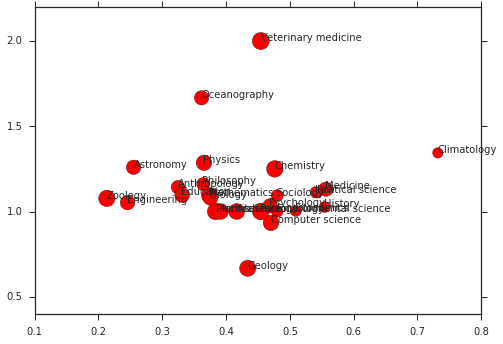

In [74]:
nodes=science.vs(depth=2)
x=zip(*nodes['color'])[0]
y=(np.array(nodes['blueacademic'])+1)/(np.array(nodes['redacademic'])+1)
plt.scatter(x,y,
            -np.log(nodes['relevance'])*30,
            'red','o')
labels=nodes['label']
for xi,yi,l in zip(x,y,labels):
    plt.text(xi,yi,l,fontsize=10)
stats.pearsonr(x,y)

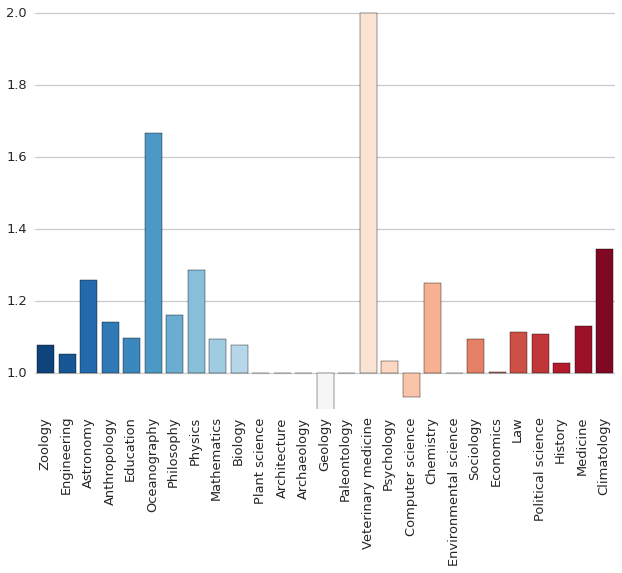

In [75]:
import matplotlib.ticker as mtick
sns.set(style="whitegrid", context="talk")
nodes=science.vs(depth=2)
x=zip(*nodes['color'])[0]
y=(np.array(nodes['blueacademic'])+1)/(np.array(nodes['redacademic'])+1)-1
labels=np.array(nodes['label'])
ax=sns.barplot(labels, y, x_order=labels[np.argsort(x)], palette="RdBu_r")
sns.despine(bottom=True,left=True)
_, labels = plt.xticks()
plt.setp(labels, rotation='vertical')
plt.ylim(-0.1,1.01);
baseline = 1
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: x+baseline))

#### breadth of engagement

(0.43830697911334121, 0.032162898837621197)

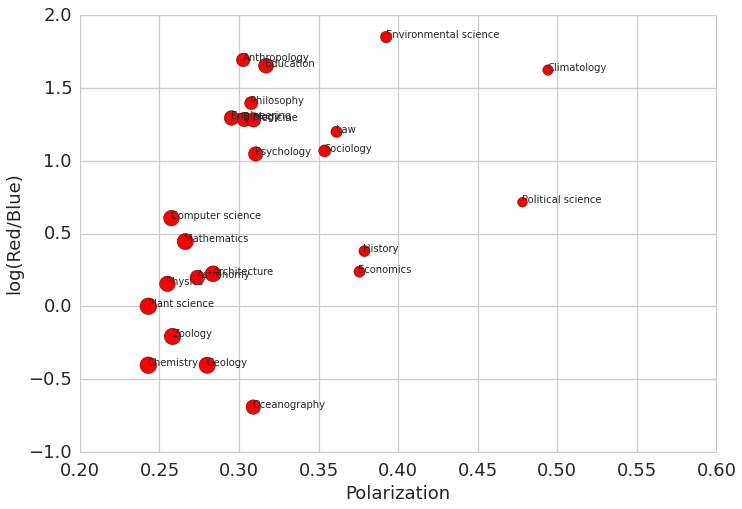

In [92]:
nodes=science.vs(depth=2)
bluecentrality=np.array(nodes['bluecentrality'])
redcentrality=np.array(nodes['redcentrality'])
x=np.array(nodes['polarization'])[redcentrality!=0]#zip(*nodes['color'])[0]
y=bluecentrality[redcentrality!=0]/redcentrality[redcentrality!=0]
plt.scatter(x,np.log(y),
            -np.log(nodes['relevance'])[redcentrality!=0]*30,
            'red','o')
plt.xlim([0.2,0.6])
labels=np.array(nodes['label'])[redcentrality!=0]
for xi,yi,l in zip(x,y,labels):
    plt.text(xi,np.log(yi),l,fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlabel('Polarization',fontsize=18)
plt.ylabel('log(Red/Blue)',fontsize=18);
plt.tight_layout()
stats.pearsonr(x,y)

#### Closeness

In [131]:
nodes=science.vs(depth=2)
blueclose=np.array(nodes['blueclose'])
redclose=np.array(nodes['redclose'])

KeyError: 'Attribute does not exist'

In [ ]:
nodes=science.vs(depth=2)
blueclose=np.array(nodes['blueclose'])
redclose=np.array(nodes['redclose'])
x=np.array(nodes['polarization'])[redcentrality!=0]#zip(*nodes['color'])[0]
y=bluecentrality[redcentrality!=0]/redcentrality[redcentrality!=0]
plt.scatter(x,np.log(y),
            -np.log(nodes['relevance'])[redcentrality!=0]*30,
            'red','o')
plt.xlim([0.2,0.6])
labels=np.array(nodes['label'])[redcentrality!=0]
for xi,yi,l in zip(x,y,labels):
    plt.text(xi,np.log(yi),l,fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlabel('Polarization',fontsize=18)
plt.ylabel('log(Red/Blue)',fontsize=18);
plt.tight_layout()
stats.pearsonr(x,y)

#### Network of copurchases

In [ ]:
copurchases={}
copurchases[D_com.vs[0]['name'],N_com.vs[0]['name']]=len(g.es(_between=(list(D_com.vs[0]['books']),list(N_com.vs[0]['books']))))
for i in N_com.vs(depth=1):
    for j in N_com.vs(depth=1):
        if i.index<j.index:
             copurchases[i['name'],j['name']]=len(g.es(_between=(list(i['books']),list(j['books']))))
for i in D_com.vs(depth=1):
    for j in D_com.vs(depth=1):
        if i.index<j.index:
             copurchases[i['name'],j['name']]=len(g.es(_between=(list(i['books']),list(j['books']))))
for i in N_com.vs(depth=1):
    for j in D_com.vs(depth=1):
        copurchases[i['name'],j['name']]=len(g.es(_between=(list(i['books']),list(j['books']))))

In [198]:
G=Graph(directed=False)
for u in D_com.vs(depth_le=1):
    G.add_vertex(u['name'])
    G.vs.find(u['name'])['size']=u['size']
    G.vs.find(u['name'])['label']=u['label']
    G.vs.find(u['name'])['relevance']=u['relevance']
    G.vs.find(u['name'])['polarization']=u['polarization']
    G.vs.find(u['name'])['alignment']=u['color'][0]
    G.vs.find(u['name'])['science']=1
for u in N_com.vs(depth_le=1):
    G.add_vertex(u['name'])
    G.vs.find(u['name'])['size']=u['size']
    G.vs.find(u['name'])['label']=u['label']
    G.vs.find(u['name'])['relevance']=u['relevance']
    G.vs.find(u['name'])['polarization']=u['polarization']
    G.vs.find(u['name'])['alignment']=u['color'][0]
    G.vs.find(u['name'])['science']=0
for key in copurchases:
    G.add_edge(key[0],key[1],weight=copurchases[key])

In [199]:
G.vs['relevance']=(G.vs['relevance']-np.mean(G.vs['relevance']))/np.std(G.vs['relevance'])*500
G.vs['polarization']=(G.vs['polarization']-np.mean(G.vs['polarization']))/np.std(G.vs['polarization'])*500
G.vs['alignment']=(G.vs['alignment']-np.mean(G.vs['alignment']))/np.std(G.vs['alignment'])*500
G.write_gml('../Disciplines/sciencevsNonscience.gml')